<a href="https://colab.research.google.com/github/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/blob/main/RSG_RWSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/RWSD" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

In [2]:
# English counterpart of RWSD: The Winograd Schema Challenge
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://dl.fbaipublicfiles.com/glue/superglue/data/v2/WSC.zip" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip

In [3]:
%%capture
%%bash
# add tree package for fancy directory display
apt-get install tree

In [4]:
# display the content of the folder
!tree

.
└── data
    ├── RWSD
    │   ├── test.jsonl
    │   ├── train.jsonl
    │   └── val.jsonl
    └── WSC
        ├── test.jsonl
        ├── train.jsonl
        └── val.jsonl

3 directories, 6 files


In [13]:
import pandas as pd
import json
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 80)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""

        data = self.read_jsonlines()

        return pd.json_normalize(data).drop(columns=['idx'])

    
    def read_jsonlines(self):
        """ yields json lines one by one """
        data = []
        with open(self.path) as f:
            for line in f:
                data.append(json.loads(line))

        return data

# Explore Train Data

In [14]:
handler = JSONL_handler('data/RWSD/train.jsonl')
df = handler.to_pandas()
handler_en = JSONL_handler('data/WCS/train.jsonl')
df_en = handler.to_pandas()

In [15]:
df.head()

,label,text,target.span1_text,target.span2_text,target.span1_index,target.span2_index
0,True,"Члены городского совета отказали организаторам митинга в разрешении, потому что они опасались насилия.",Члены городского совета,они опасались,0,10
1,False,"Члены городского совета отказали организаторам митинга в разрешении, потому что они опасались насилия.",организаторам митинга,они опасались,4,10
2,False,"Члены городского совета отказали организаторам митинга в разрешении, потому что они одобряли насилие.",Члены городского совета,они одобряли,0,10
3,True,"Члены городского совета отказали организаторам митинга в разрешении, потому что они одобряли насилие.",организаторам митинга,они одобряли,4,10
4,True,"Кубок не помещается в коричневый чемодан, потому что он слишком большой.",Кубок,он слишком большой,0,8


In [16]:
import matplotlib.pyplot as plt

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


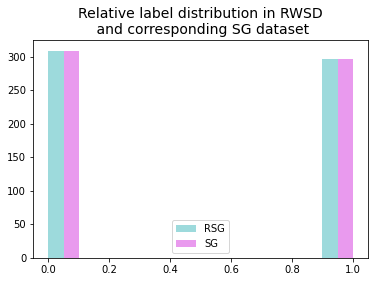

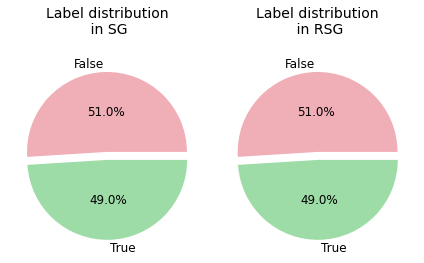

In [17]:
plt.title('Relative label distribution in RWSD\n and corresponding SG dataset',
          fontsize=14)
plt.hist(x = [df['label'], df_en['label']],
         color=["#9ddadc", "#e99aee"],
         label=['RSG','SG'], rwidth = 50) 
plt.legend(loc='best')
plt.show()
print()

plt.subplot(1,2,1)
colours = {'#9ddca6', '#f0afb6', '#eeb87c'}

plt.title('Label distribution\n in SG\n', fontsize=14)
plt.pie(df_en['label'].value_counts(), autopct="%.1f%%",
        explode=[0.05]*2, labels=df_en['label'].value_counts().keys(),
        pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.subplot(1,2,2)

plt.title('Label distribution\n in RSG\n', fontsize=14)
plt.pie(df['label'].value_counts(), autopct="%.1f%%",
        explode=[0.05]*2, labels=df['label'].value_counts().keys(),
        pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.tight_layout()
plt.show()

# Check if val data have similar label distributions

In [18]:
val_handler = JSONL_handler('data/RWSD/val.jsonl')
val_df = val_handler.to_pandas()
val_handler_en = JSONL_handler('data/WSC/val.jsonl')
val_df_en = val_handler_en.to_pandas()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


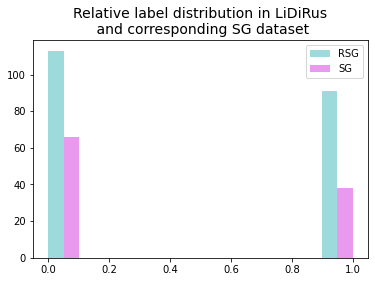

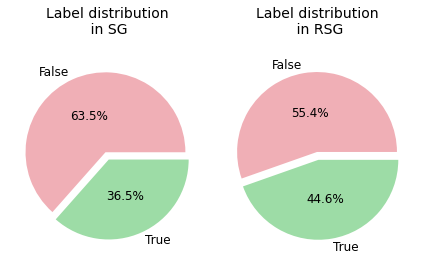

In [19]:
plt.title('Relative label distribution in LiDiRus\n and corresponding SG dataset', fontsize=14)
plt.hist(x = [val_df['label'], val_df_en['label']],
         color=["#9ddadc", "#e99aee"], label=['RSG','SG'], rwidth = 50) 
plt.legend(loc='best')
plt.show()
print()

plt.subplot(1,2,1)
colours = {'#9ddca6', '#f0afb6', '#eeb87c'}

plt.title('Label distribution\n in SG\n', fontsize=14)
plt.pie(val_df_en['label'].value_counts(),
        autopct="%.1f%%", explode=[0.05]*2,
        labels=val_df_en['label'].value_counts().keys(),
        pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.subplot(1,2,2)

plt.title('Label distribution\n in RSG\n', fontsize=14)
plt.pie(val_df['label'].value_counts(),
        autopct="%.1f%%", explode=[0.05]*2,
        labels=val_df['label'].value_counts().keys(),
        pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.tight_layout()
plt.show()

In [21]:
df.iloc[10:20]

,label,text,target.span1_text,target.span2_text,target.span1_index,target.span2_index
10,False,"Женя поблагодарила Сашу за помощь, которую она оказала.",Женя,она оказала,0,6
11,True,"Женя поблагодарила Сашу за помощь, которую она оказала.",Сашу,она оказала,2,6
12,True,"Павел звонил Георгию по телефону, но он не дозвонился.",Павел,он не дозвонился,0,6
13,False,"Павел звонил Георгию по телефону, но он не дозвонился.",Георгию,он не дозвонился,2,6
14,False,"Павел звонил Георгию по телефону, но он не ответил.",Павел,он не ответил,0,6
15,True,"Павел звонил Георгию по телефону, но он не ответил.",Георгию,он не ответил,2,6
16,True,"Адвокат задал свидетелю вопрос, но не захотел его повторить.",Адвокат,не захотел,0,5
17,False,"Адвокат задал свидетелю вопрос, но не захотел его повторить.",свидетелю,не захотел,2,5
18,False,"Адвокат задал свидетелю вопрос, но тот не смог ему на него ответить.",Адвокат,не смог,0,6
19,True,"Адвокат задал свидетелю вопрос, но тот не смог ему на него ответить.",свидетелю,не смог,2,6
